In [2]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']
num_votazioni = 50
num_film = 5

In [3]:
#PRELEVO LE VARIE PRODUZIONI 
df_production = pd.DataFrame(db.production_companies.find({}))
df_production.head()

,_id,name
0,3,Pixar Animation Studios
1,559,TriStar Pictures
2,2550,Teitler Film
3,10201,Interscope Communications
4,6194,Warner Bros.


In [4]:
df_production = df_production.rename(columns= {'_id' : 'production_companies'})

In [5]:
#PRELEVO I VARI FILM
df_film= pd.DataFrame( db.metadata.aggregate([ {'$project': {'_id': 1, 'production_companies': 1,'vote_average':1,'vote_count':1,'budget':1,'original_title':1}
    }]))
df_film

,_id,budget,original_title,production_companies,vote_average,vote_count
0,862,30000000,Toy Story,[3],7.7,5415.0
1,8844,65000000,Jumanji,"[559, 2550, 10201]",6.9,2413.0
2,15602,0,Grumpier Old Men,"[6194, 19464]",6.5,92.0
3,31357,16000000,Waiting to Exhale,[306],6.1,34.0
4,11862,0,Father of the Bride Part II,"[5842, 9195]",5.7,173.0
...,...,...,...,...,...,...
45428,439050,0,رگ خواب,None,4.0,1.0
45429,111109,0,Siglo ng Pagluluwal,[19653],9.0,3.0
45430,67758,0,Betrayal,[6165],3.8,6.0
45431,227506,0,Satana likuyushchiy,[88753],0.0,0.0


In [6]:
#CONVERTO BUDGET IN INTERO
df_film.budget = df_film.budget.astype(str).astype(int)

In [7]:
#CONVERTO _ID IN INTERO
df_film._id = df_film._id.astype(str).astype(int)

In [8]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
df_film = df_film.explode('production_companies')



In [9]:
#FILTRO, PRELEVANDO SOLO I FILM CHE HANNO AVUTO UN CERTO NUMERO DI VOTI
df_film = df_film.mask(df_film.eq('None')).dropna()
df_film = df_film.loc[df_film['vote_count'] >= num_votazioni]    

C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\monob\anaconda3\envs\py37\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [10]:
#CONTROLLO CHE NON CI SIANO NULL 
df_film.isna().sum()

_id                     0
budget                  0
original_title          0
production_companies    0
vote_average            0
vote_count              0
dtype: int64

In [11]:
(df_film.production_companies=="None").value_counts()

False    25940
Name: production_companies, dtype: int64

In [12]:
#ELIMINO LE RIGHE CHE HANNO BUDGET 0
index_target = df_film[ df_film.budget == 0 ].index

In [13]:
 df_film.drop(index_target , inplace=True)

In [14]:
df_film

,_id,budget,original_title,production_companies,vote_average,vote_count
0,862,30000000,Toy Story,3,7.7,5415.0
1,8844,65000000,Jumanji,559,6.9,2413.0
1,8844,65000000,Jumanji,2550,6.9,2413.0
1,8844,65000000,Jumanji,10201,6.9,2413.0
5,949,60000000,Heat,508,7.7,1886.0
...,...,...,...,...,...,...
45174,407448,34000000,Detroit,8411,7.3,67.0
45174,407448,34000000,Detroit,13184,7.3,67.0
45174,407448,34000000,Detroit,20344,7.3,67.0
45235,277839,5402000,Pattaya,57294,5.3,153.0


In [15]:
#FACCIO JOIN CON IL DATAFRAME CONTENENTE LE PRODUZIONI
df_H1 = pd.merge(df_film, df_production, on='production_companies')

df_H1


,_id,budget,original_title,production_companies,vote_average,vote_count,name
0,862,30000000,Toy Story,3,7.7,5415.0,Pixar Animation Studios
1,9487,120000000,A Bug's Life,3,6.8,2379.0,Pixar Animation Studios
2,863,90000000,Toy Story 2,3,7.3,3914.0,Pixar Animation Studios
3,585,115000000,"Monsters, Inc.",3,7.5,6150.0,Pixar Animation Studios
4,12,94000000,Finding Nemo,3,7.6,6292.0,Pixar Animation Studios
...,...,...,...,...,...,...,...
17019,452068,4000000,Drone,92103,5.7,55.0,Daylight Media
17020,341013,30000000,Atomic Blonde,87733,6.1,748.0,Closed on Mondays Entertainment
17021,374720,100000000,Dunkirk,67254,7.5,2712.0,Kaap Holland Film
17022,395834,11000000,Wind River,27497,7.4,181.0,Star Thrower Entertainment


In [16]:
#produzioni che hanno fatto più film
target = df_H1.groupby('production_companies').count()
target.reset_index(inplace=True)
target =  target.rename(columns = {'name' : 'count'})
target = target.loc[target['count'] >= 250]
target = target.drop(['_id','budget','original_title','vote_average','vote_count'], axis=1)
target

,production_companies,count
3,4,340
23,33,385
177,306,284
1762,6194,412


In [17]:
df_H = pd.merge(df_H1, target, on='production_companies')
df_H

,_id,budget,original_title,production_companies,vote_average,vote_count,name,count
0,949,60000000,Heat,6194,7.7,1886.0,Warner Bros.,412
1,9273,30000000,Ace Ventura: When Nature Calls,6194,6.1,1128.0,Warner Bros.,412
2,9691,50000000,Assassins,6194,6.0,394.0,Warner Bros.,412
3,11859,50000000,Fair Game,6194,4.1,54.0,Warner Bros.,412
4,688,24000000,The Bridges of Madison County,6194,7.3,397.0,Warner Bros.,412
...,...,...,...,...,...,...,...,...
1416,356305,38000000,Why Him?,306,6.3,1203.0,Twentieth Century Fox Film Corporation,284
1417,263115,97000000,Logan,306,7.6,6310.0,Twentieth Century Fox Film Corporation,284
1418,295693,125000000,The Boss Baby,306,6.1,2336.0,Twentieth Century Fox Film Corporation,284
1419,126889,97000000,Alien: Covenant,306,5.7,2677.0,Twentieth Century Fox Film Corporation,284


In [18]:
data=df_H[df_H['production_companies'] == 33]
data=data[['budget','vote_average','name']]
data

,budget,vote_average,name
752,35000000,5.5,Universal Pictures
753,52000000,7.8,Universal Pictures
754,29500000,7.4,Universal Pictures
755,30000000,6.0,Universal Pictures
756,12000000,6.5,Universal Pictures
...,...,...,...
1132,75000000,6.8,Universal Pictures
1133,22000000,6.6,Universal Pictures
1134,55000000,6.0,Universal Pictures
1135,125000000,5.4,Universal Pictures


In [19]:
data1=df_H[df_H['production_companies'] == 6194]
data1=data1[['budget','vote_average','name']]
data1

,budget,vote_average,name
0,60000000,7.7,Warner Bros.
1,30000000,6.1,Warner Bros.
2,50000000,6.0,Warner Bros.
3,50000000,4.1,Warner Bros.
4,24000000,7.3,Warner Bros.
...,...,...,...
407,185000000,6.2,Warner Bros.
408,175000000,6.5,Warner Bros.
409,25000000,6.2,Warner Bros.
410,25000000,6.6,Warner Bros.


In [20]:
data2=df_H[df_H['production_companies'] == 4]
data2=data2[['budget','vote_average','name']]
data2

,budget,vote_average,name
412,58000000,6.2,Paramount Pictures
413,12000000,6.9,Paramount Pictures
414,45000000,5.9,Paramount Pictures
415,20000000,5.8,Paramount Pictures
416,8169363,6.1,Paramount Pictures
...,...,...,...
747,85000000,5.5,Paramount Pictures
748,25000000,4.8,Paramount Pictures
749,110000000,5.9,Paramount Pictures
750,69000000,6.1,Paramount Pictures


Text(0.5, 1.0, 'Warner Bros')

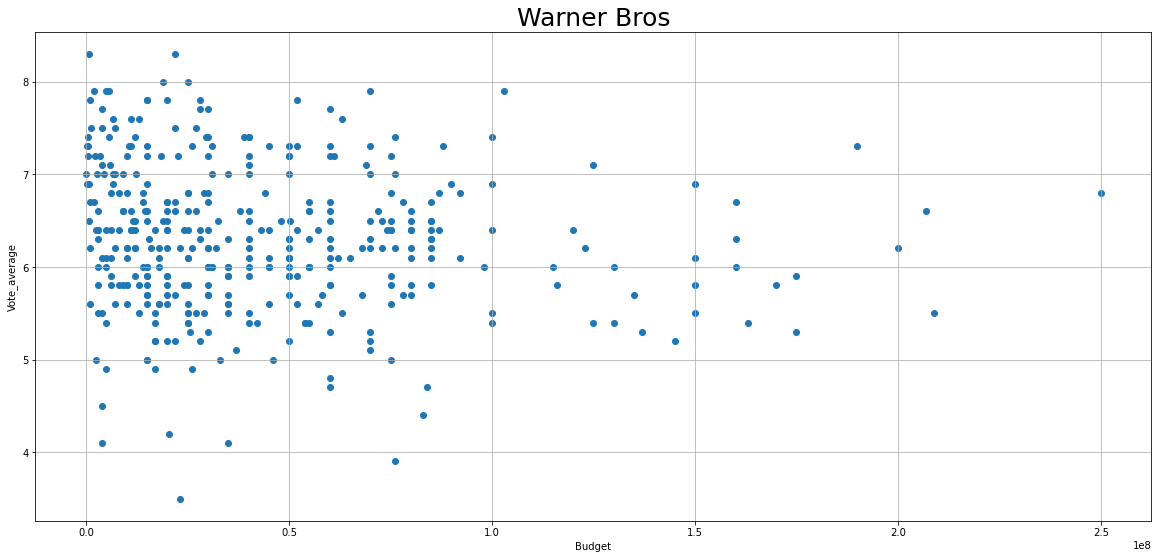

In [21]:
#VEDO SE CI STA UNA CORRELAZIONE TRA IL BUDGET SPESO DSLLA PRODUZIONE DEL FILM E IL SUO VOTO
plt.figure(figsize=(20,9))
plt.grid()
plt.scatter(data.budget,data.vote_average)

plt.ylabel('Vote_average')
plt.xlabel('Budget')
plt.title('Warner Bros',fontsize=25)

Text(0.5, 1.0, 'Paramount Pictures')

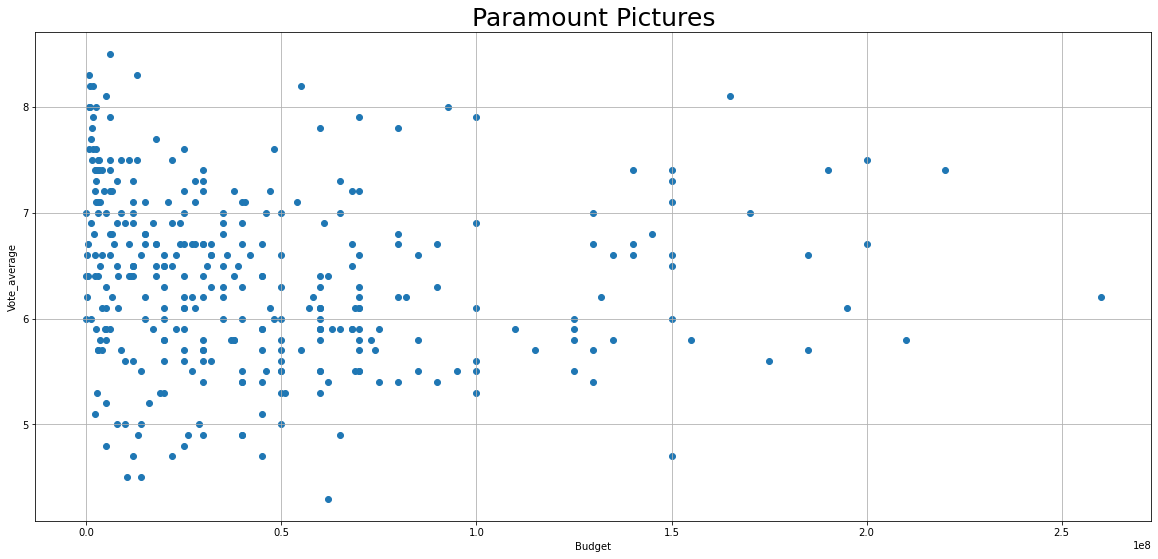

In [26]:
#VEDO SE CI STA UNA CORRELAZIONE TRA IL BUDGET SPESO DSLLA PRODUZIONE DEL FILM E IL SUO VOTO
plt.figure(figsize=(20,9))
plt.grid()
plt.scatter(data2.budget,data2.vote_average)

plt.ylabel('Vote_average')
plt.xlabel('Budget')
plt.title('Paramount Pictures',fontsize=25)

Text(0.5, 1.0, 'Universal Pictures')

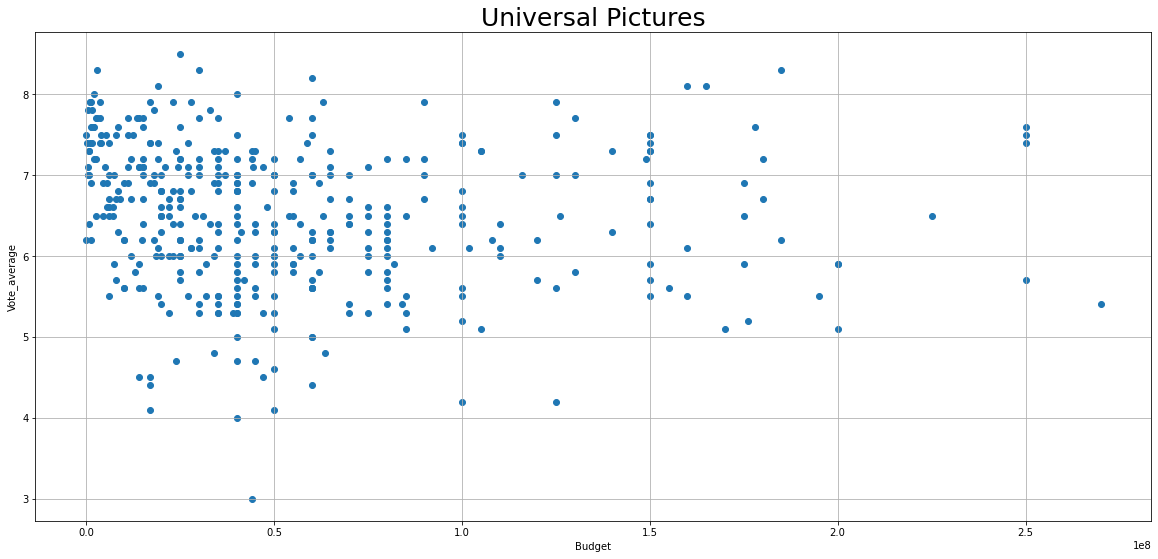

In [23]:
#VEDO SE CI STA UNA CORRELAZIONE TRA IL BUDGET SPESO DSLLA PRODUZIONE DEL FILM E IL SUO VOTO
plt.figure(figsize=(20,9))
plt.grid()
plt.scatter(data1.budget,data1.vote_average)

plt.ylabel('Vote_average')
plt.xlabel('Budget')
plt.title('Universal Pictures',fontsize=25)

In [24]:
data.describe()

,budget,vote_average
count,3.850000e+02,385.000000
mean,4.392801e+07,6.300779
std,4.124347e+07,0.785795
min,2.500000e+01,3.500000
25%,1.500000e+07,5.800000
50%,3.000000e+07,6.300000
75%,6.000000e+07,6.800000
max,2.500000e+08,8.300000


In [25]:
data1.describe()

,budget,vote_average
count,4.120000e+02,412.000000
mean,5.470346e+07,6.499515
std,5.134648e+07,0.885460
min,1.000000e+00,3.000000
25%,1.900000e+07,5.900000
50%,4.000000e+07,6.500000
75%,7.500000e+07,7.200000
max,2.700000e+08,8.500000


In [27]:
data2.describe()

,budget,vote_average
count,3.400000e+02,340.000000
mean,4.568551e+07,6.376471
std,4.728643e+07,0.821381
min,1.000000e+00,4.300000
25%,1.100000e+07,5.800000
50%,3.000000e+07,6.400000
75%,6.225000e+07,7.000000
max,2.600000e+08,8.500000
